#**Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#**Loading Dataset**

In [2]:
# Load Data
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

#**Data Cleaning & EDA**

In [3]:
# Data Cleaning & EDA
def clean_and_eda(df):
    # Replace '?' with NaN
    df.replace('?', np.nan, inplace=True)

    # Check for missing values
    print("Missing values in each column:\n", df.isnull().sum())

    # Ensure 'income' column (target) has no NaN values
    if df['income'].isnull().sum() > 0:
        print("\nWarning: 'income' column contains NaN values. Filling NaN values with mode.")
        df['income'].fillna(df['income'].mode()[0], inplace=True)

    # Basic statistics
    print("\nBasic statistics:\n", df.describe(include='all'))

    # Class distribution
    plt.figure(figsize=(6,4))
    sns.countplot(x='income', data=df)
    plt.title('Class Distribution')
    plt.show()

    # Correlation matrix for numerical features only
    plt.figure(figsize=(12,8))
    corr_matrix = df.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

    # Distribution of 'capital.gain' feature
    plt.figure(figsize=(6,4))
    sns.histplot(df['capital.gain'], bins=50, kde=True)
    plt.title('Distribution of Capital Gain')
    plt.show()

    return df

#**Handling Missing Values**

In [4]:
# Handle Missing Values
def handle_missing_values(df):
    # For categorical columns, fill missing values with the mode
    for column in df.select_dtypes(include=['object']).columns:
        df[column].fillna(df[column].mode()[0], inplace=True)

    # For numerical columns, fill missing values with the mean
    imputer = SimpleImputer(strategy='mean')
    df[df.select_dtypes(include=[np.number]).columns] = imputer.fit_transform(df.select_dtypes(include=[np.number]))

    return df

#**Feature Encoding**

In [5]:
# Feature Encoding
def encode_features(df):
    # Encode categorical variables into numerical format
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le
    return df, label_encoders

#**Feature Scaling**

In [6]:
# Feature Scaling
def scale_features(df):
    scaler = StandardScaler()
    df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])
    return df

#**Handling Imbalance**

In [7]:
# Handling Imbalance
def handle_imbalance(df, method='smote'):
    X = df.drop('income', axis=1)
    y = df['income']

    if method == 'smote':
        sm = SMOTE(random_state=42)
        X_res, y_res = sm.fit_resample(X, y)
    elif method == 'undersample':
        rus = RandomUnderSampler(random_state=42)
        X_res, y_res = rus.fit_resample(X, y)
    elif method == 'combine':
        smote_enn = SMOTEENN(random_state=42)
        X_res, y_res = smote_enn.fit_resample(X, y)
    else:
        X_res, y_res = X, y

    return X_res, y_res

#**Baseline Model Training**

In [8]:
# Baseline Model Training
def train_baseline_models(X, y):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'SVM': SVC(),
        'XGBoost': XGBClassifier()
    }

    results = {}
    for name, model in models.items():
        skf = StratifiedKFold(n_splits=5)
        cv_results = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
        results[name] = cv_results.mean()
        print(f'{name}: ROC-AUC = {cv_results.mean():.4f}')

    return results

#**Baseline & SMOTE Results**

Missing values in each column:
 age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

Basic statistics:
                  age workclass        fnlwgt education  education.num  \
count   32561.000000     30725  3.256100e+04     32561   32561.000000   
unique           NaN         8           NaN        16            NaN   
top              NaN   Private           NaN   HS-grad            NaN   
freq             NaN     22696           NaN     10501            NaN   
mean       38.581647       NaN  1.897784e+05       NaN      10.080679   
std        13.640433       NaN  1.055500e+05       NaN       2.572720   
min        17.000000       NaN  1.228500e+04       NaN       1.000000   
25%   

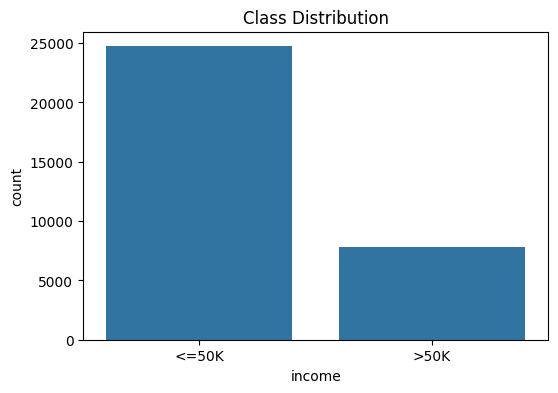

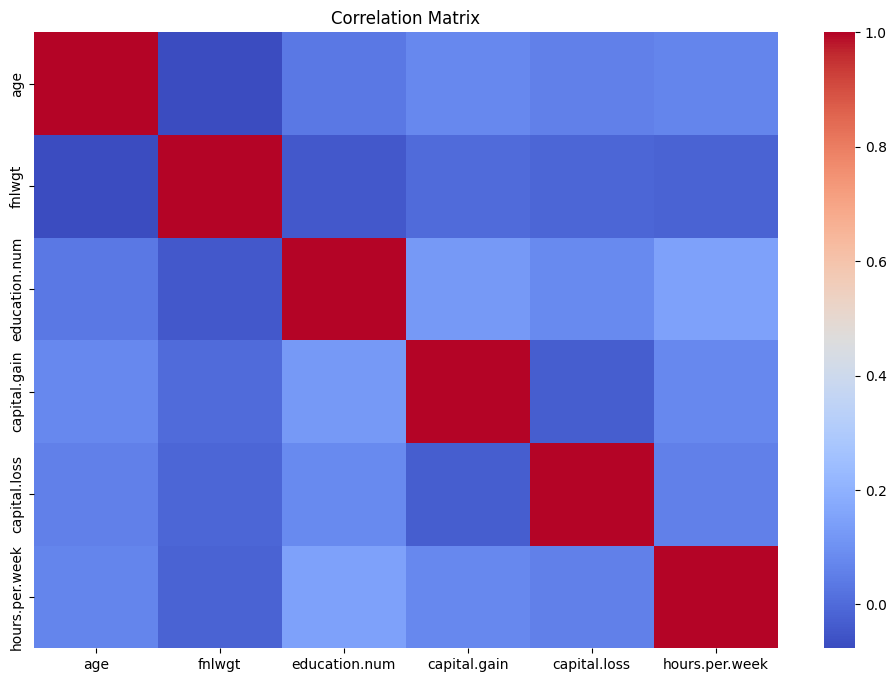

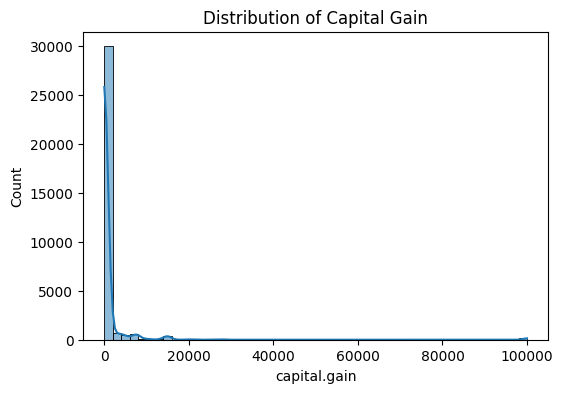


Running baseline models on imbalanced data...

Logistic Regression: ROC-AUC = 0.8474
Decision Tree: ROC-AUC = 0.6704
Random Forest: ROC-AUC = 0.8573
SVM: ROC-AUC = 0.8744
XGBoost: ROC-AUC = 0.8265

Applying SMOTE and retraining models...

Logistic Regression: ROC-AUC = 0.8430
Decision Tree: ROC-AUC = 0.8275
Random Forest: ROC-AUC = 0.9405
SVM: ROC-AUC = 0.9055
XGBoost: ROC-AUC = 0.9311

Balanced dataset saved to balanced_adult.csv


Baseline Results:
 {'Logistic Regression': 0.8474151160884741, 'Decision Tree': 0.6704106691870162, 'Random Forest': 0.857340530183289, 'SVM': 0.874449414535657, 'XGBoost': 0.8265468327028695}

SMOTE Results:
 {'Logistic Regression': 0.8430303378420836, 'Decision Tree': 0.8275283171521035, 'Random Forest': 0.9404838888103392, 'SVM': 0.9054602813648789, 'XGBoost': 0.9310638373079462}


In [9]:
def full_pipeline(file_path):
    df = load_data(file_path)
    df = clean_and_eda(df)
    df = handle_missing_values(df)
    df, _ = encode_features(df)
    df = scale_features(df)

    print("\nRunning baseline models on imbalanced data...\n")
    X, y = df.drop('income', axis=1), df['income']
    baseline_results = train_baseline_models(X, y)

    print("\nApplying SMOTE and retraining models...\n")
    X_res, y_res = handle_imbalance(df, method='smote')
    smote_results = train_baseline_models(X_res, y_res)

    # Convert X_res back to DataFrame and add 'income' column
    df_resampled = pd.DataFrame(X_res, columns=df.columns[:-1])
    df_resampled['income'] = y_res.values

    # Save the balanced dataset to a CSV file
    balanced_file_path = 'balanced_adult.csv'
    df_resampled.to_csv(balanced_file_path, index=False)
    print(f"\nBalanced dataset saved to {balanced_file_path}\n")

    print("\nBaseline Results:\n", baseline_results)
    print("\nSMOTE Results:\n", smote_results)

# Path of dataset
file_path = 'adult.csv'
full_pipeline(file_path)